# SCRIPT : FermatKMedoïds and coefficient of variation  
# Moons dataset

1. [Motivation](#part1)
2. [Dataset](#part2)
3. [FermatKMedoïds on the non preprocess data set](#part3)
4. [FermatKMedoids on the preprocess data set](#part4)
5. [Fermat distance Coefficient of variation](#part5)

In [27]:
import seaborn as sns
sns.set()
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score
#from sklearn.metrics import fowlkes_mallows_score
import pandas as pd
from fermat.clusterize import *
from fermat.preprocessing import *

# Motivation <a id="part1"></a>

We would like to experiment the **K-medoïds algorithm** on synthetic dataset using the **Fermat distance**. We denote this algorithm by **Fermat-KMedoïds**. Our goal here is to characterize the **Fermat distance**. Which means that considering a clustering problem, we don't aim at finding specific algorithms, rather we are interested in understanding the sensitivity of the Fermat distance to its parameter $\alpha$.

The **Fermat KMedoïds** algorithm aims at minimizing the **sample Fermat distance** between the observation and the centroïd of the cluster to which it belongs. Given an i.i.d. sample $\mathbb{X}_n=(X_1,\dots,X_n)$ and $K \in \mathbb{N}$ the number of clusters, the Fermat KMedoïds algorithm is characterized by the minimization of the objective over all possible partitionning of the sample $(C_1,\dots,C_K)$ :  

$$
\underset{(C_1,\dots,C_K)}{minimize} \sum_{l = 1}^K \sum_{X \in C_l} D_{\alpha}^n(X, X^l),
$$

where $X^l \in \left\{ C_l \cap \mathbb{X}_n \right\}$ is defined as the centroïd of the cluster $C_l$, and $D_{\alpha}^n(X, X^l)$ denotes the Fermat distance with parameter $\alpha$. 

We use two performance criteria :  

- Adjusted Mutual information 
- Adjusted Rand Index     
    
In this notebook we perform Fermat-KMedoïds on the 'Moons' dataset and we compute an estimation of the coefficient of variation of the Fermat distance between two points of the set. The plan of work is based on the three following goals.

1. We would like to verify if we observe an $\alpha_0$ value that garanties a good clustering performance. Where good is understood in respect of the above performance criteria. In other words, a meaningful distance is obtained only for a sufficiently large value of $\alpha$.
  
2. On the other hand, using very large $\alpha$ comes with strong disavantages: large variability and computational precision problem. We expect to observe a $\bar{\alpha}$ above wich the clustering performances are declining and the coefficient of variation is going beyond a certain value. 
  
3. As a possible solution to these issues, we preprocess the data using 'harmonizers'. We will analyse how this might help (or not) to lower the variational coefficient of the sample Fermat distance while increasing clustering performances. 

- We import the **FermatKMeans** algorithm in the module *clusterize.py* from the python library : https://github.com/Fermat-distance/fermat

In [12]:
from fermat.clusterize import *

- We import the harmonize_points function in the module *preprocessing.py* from the python library : https://github.com/Fermat-distance/fermat

In [13]:
from fermat.preprocessing import *

# Dataset <a id="part2"></a>

- We simulate and visualize the synthetic data set

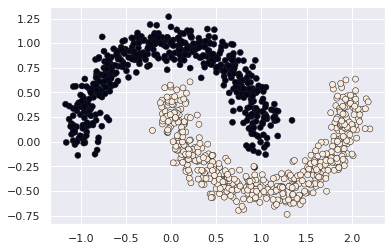

In [4]:
#Data simulation
seed=0
np.random.seed(seed)
n = 1000
X, labels = make_moons(n_samples=n,noise=0.1)
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X[:,0], X[:,1], c=labels, edgecolor='k', linewidths=0.5, label='true');

# FermatKMedoids on the non preprocessed data <a id="part3"></a>

The following script runs the FermatKMeans algorithm on the non preprocessed dataset. Each iteration, the performances criteria for the different alpha values are saved.  
  
Parameters - value:
- n : (int) Sample size - 1000
- n_xp : (int) Number of iterations of the experience - 1000

- cluster_qty : (int) Number of clusters - 2
- dataset : (str) Name of the dataset (for figure title) - 'Moons data set'
- h : (int) Choice of the harmonization or not - 0 (No preprocessing) 
- all_alpha : (array) values of the parameter alpha - np.linspace(1, 8, 29, endpoint=True) 
- titlecsv : (str) path/name.csv of the csv file to save the performances - titlecsv_AMI = 'xp_result/Moons_R_AMI.csv' and titlecsv_ARI = 'xp_result/Moons_R_ARI.csv'

In [ ]:
%%time
##########################################

#Clustering parameters
n = 1000 #Sample size
n_xp = 1000 #Number of experiences

cluster_qty = 2
dataset = 'Moons data set'
h = 0
harmonizer = ['Raw data','Knn','Epsilon_radius','Delaunay'][h]
#n_harmonizations = 1
#k = Best_param #Need to be optimized first
#k = 20
#eps = Best_param #Need to be optimized first
#eps = 0.25

all_alpha = np.linspace(1, 8, 29, endpoint=True) #Fermat dist parameter

titlecsv_AMI = 'xp_result/Moons_R_AMI.csv'
titlecsv_ARI = 'xp_result/Moons_R_ARI.csv'
##########################################

#Clustering
#(list of list shape(n_xp, len(all_alpha))) - Save permances for each alpha and each experience 
AMI_ = [] #Adjusted mutual information 
ARI_ = [] #Adjusted rand score

for seed in np.arange(n_xp):
    
    #Data simulation and preprocess
    X, labels = make_moons(n_samples=n,noise=0.1)
    if harmonizer != 'Raw data':
        for _ in np.arange(n_harmonizations):
            X = harmonize_points(X, method=harmonizer, k=k, eps=eps, include_self=False)

    Pred = [] #Labels predictions
    ami = [] #Performance for criterion AMI
    ari = []
    for alpha in all_alpha:
        Fermat_clustering = FermatKMeans(cluster_qty=cluster_qty, alpha=alpha, path_method='FW', iterations=5,seed=seed)
        labels_pred = Fermat_clustering.fit_predict(X)
        Pred.append(labels_pred)
        ami.append(adjusted_mutual_info_score(labels,labels_pred))
        ari.append(adjusted_rand_score(labels,labels_pred))
    
    plt.plot(all_alpha, ami,'-.',alpha=0.3, linewidth=1);
    AMI_.append(ami)
    ARI_.append(ari)
    
AMI_ = np.array(AMI_) #shape(n_xp,len(all_alpha))
ARI_ = np.array(ARI_) #shape(n_xp,len(all_alpha))

#SAVE
pd.DataFrame(AMI_).to_csv(titlecsv_AMI, index=False) 
pd.DataFrame(ARI_).to_csv(titlecsv_ARI, index=False)

# FermarKMedoids on the preprocessed data (Harmonizer)  <a id="part4"></a>

The following script runs the FermatKMeans algorithm on the harmonized dataset. Each iteration, the code is looking for the best harmonizer parameter and keeps in memory the performances criteria for the different alpha values.  
  
Parameters :
- n_xp : (int) Number of iterations of the experience
- h : (int) 1 : Knn- harmonization, 2 : Epsilon_radius harmonization, 3 : Delaunay harmonization (bad here) 
- param_values : (array) values for the harmonizer's parameter each iteration picks the parameter with the highest performance
- titlecsv : (str) path/name.csv of the csv file to save the performances

# FAIRE TOURNER CE SCRIPT POUR n_xp=1000
# !! et h = 1 et h = 2 en ajustant param values et titlecsv !!

## 01 septembre tourne pour k_val  2 3 4 n_xp = 250 OK
## 01 septembre tourne pour k_val  5 6 7 8 9 10 11 12 13 14 15 n_xp = 250
## 05 septembre tourne pour eps np.linspace(0.07, 0.2 , 14)
## 07 septembre tourne pour k_val  2 3 4 5 6 7 8 9 10 11 12 13 14 15 n_xp = 250

In [ ]:
%%time

#Data simulation
#seed = 0
#np.random.seed(seed)
#n = 1000
#X, labels = make_moons(n_samples=n,noise=0.1)

##########################################
#Clustering parameters
n = 1000 #Sample size
n_xp = 250 #number of experiences

cluster_qty = 2
dataset = 'Moons data set'
h = 1
#h = 2
harmonizer = ['Raw data','Knn','Epsilon_radius','Delaunay'][h]
n_harmonizations = 1

#k = 20
#k_values = np.arange(2,25,1)
#k_values = np.arange(2,5,1)
k_values = np.arange(2,19,1)
#k_values = np.arange(10,15,1)
#eps = 0.25
#eps_values = np.linspace(0.05,0.25,21)
eps_values = np.linspace(0.07, 0.2 , 14)

param_values = k_values

all_alpha = np.linspace(1, 8, 29, endpoint=True) #Fermat dist parameter

titlecsv_Param_ami = 'xp_result/Moons_Kopti2_20_nxp_250_ami.csv'
titlecsv_Param_ari = 'xp_result/Moons_Kopti2_20_nxp_250_ari.csv'
titlecsv_AMI = 'xp_result/Moons_K2_20_nxp_250_AMI.csv'
titlecsv_ARI = 'xp_result/Moons_K2_20_nxp_250_ARI.csv' 
##########################################
#Figure parameters
#titlefig = 'xp_result/Moon_Harmonizer_Opti.png'
#plt.figure(figsize=(12,6.5))

##########################################
#Clustering
Best_param_ami = [] #Parameter of the harmonizer (k/eps) for the best performance
Best_AMI_ = []#We keep the performances of the selected parameter in respect of alpha

Best_param_ari = [] #Parameter of the harmonizer (k/eps) for the best performance
Best_ARI_ = []#We keep the performances of the selected parameter in respect of alpha

for seed in np.arange(n_xp):
    
    np.random.seed(seed)
    X, labels = make_moons(n_samples=n,noise=0.1)#data simulation
    
    AMI_ = [] #Save performances for each param (k/eps)
    Pmax_ami = [] #Save Performance_max for each param (k/eps)
    Imax_ami = [] #Save alpha index corresponding to the best performance for each param (k/eps)
    
    ARI_ = [] #Save performances for each param (k/eps)
    Pmax_ari = [] #Save Performance_max for each param (k/eps)
    Imax_ari = [] #Save alpha index corresponding to the best performance for each param (k/eps)
    
    for k in param_values:
    #for eps in param_values:
        H = harmonize_points(X, method=harmonizer, k=k, eps=eps, include_self=False)
        
        Pred = [] #FermatKMedoids predictions
        
        for alpha in all_alpha:
            Fermat_clustering = FermatKMeans(cluster_qty=cluster_qty, alpha=alpha, path_method='FW', iterations=5)
            labels_pred = Fermat_clustering.fit_predict(H)
            Pred.append(labels_pred)
            
        AMI_.append([]) 
        ARI_.append([])
        
        for preds in Pred:
            AMI_[-1].append(adjusted_mutual_info_score(labels,preds))
            ARI_[-1].append(adjusted_rand_score(labels,preds))
        
        Pmax_ami.append(np.max(np.array(AMI_[-1])))
        Pmax_ari.append(np.max(np.array(ARI_[-1])))
    
    #For each experience save the Best param and its Performances in respect of alpha
    param_ind_ami = np.argmax(Pmax_ami) #index of the Best_P is the index of the corresponding parameter
    Best_AMI_.append(AMI_[param_ind_ami]) 
    Best_param_ami.append(param_values[param_ind_ami])
    
    param_ind_ari = np.argmax(Pmax_ari) #index of the Best_P is the index of the corresponding parameter
    Best_ARI_.append(ARI_[param_ind_ari]) 
    Best_param_ari.append(param_values[param_ind_ari])

#Save Performances and parameters in csv file   
Best_param_ami = np.array(Best_param_ami) #array of shape(n_xp,)
Best_AMI_ = np.array(Best_AMI_) #array of shape(n_xp, len(all_alphas))

Best_param_ari = np.array(Best_param_ari) #array of shape(n_xp,)
Best_ARI_ = np.array(Best_ARI_) #array of shape(n_xp, len(all_alphas))

pd.DataFrame(Best_param_ami).to_csv(titlecsv_Param_ami, index=False) 
pd.DataFrame(Best_param_ari).to_csv(titlecsv_Param_ari, index=False) 
pd.DataFrame(Best_AMI_).to_csv(titlecsv_AMI, index=False) 
pd.DataFrame(Best_ARI_).to_csv(titlecsv_ARI, index=False) 

# Fermat distance Coefficient of Variation <a id="part5"></a>

In [1]:
from fermat.L_fermat_stat import *

## CV_Nonpreprocessed data : Run on the 10th of September

In [ ]:
%%time
##########################################
seed=0
#Clustering parameters
n = 1000 #Sample size
n_xp = 250 #Number of experiences
d = 2
#cluster_qty = 2
dataset = 'Moons data set'
h = 0
harmonizer = [None,'Knn','Epsilon_radius','Delaunay'][h]
#n_harmonizations = 1
#k = Best_param #Need to be optimized first
k = None
#eps = Best_param #Need to be optimized first
eps = None

all_alpha = np.linspace(1.1, 8.1, 29, endpoint=True) #Fermat dist parameter
titlecsv = 'xp_result/CV_moons_R.csv'
###########################################

#Fermat dist parameter
x = np.array([-0.25,1])
y = np.array([0.,0.5])
#titlecsv = "xp_result/CV_moons_1.csv"

##########################################

df_ = fermat_simu_moons(n=n, d=d, alphas=all_alpha,x=x,y=y,n_simulations=n_xp,harmonizer=harmonizer,k=None,eps=None,seed=seed)
df_.to_csv(titlecsv, index=False)
#df_combined = process_df(df_)

## CV_Knn harmonized data : Run on the 12th of September

In [ ]:
%%time
##########################################
seed=0
#Clustering parameters
n = 1000 #Sample size
#n_xp = 250 #Number of experiences
d = 2
#cluster_qty = 2
dataset = 'Moons data set'
h = 1
harmonizer = [None,'Knn','Epsilon_radius','Delaunay'][h]
#n_harmonizations = 1
#k = Best_param #Need to be optimized first
k_values = pd.read_csv('xp_result/Moons_Kopti5_15_nxp_250_ami.csv')
k_values = k_values.to_numpy() # The best param for each clustering experience. !!array of arrays!!
#k_values = k_values[:3]
#eps = Best_param #Need to be optimized first
eps = None

all_alpha = np.linspace(1.1, 8.1, 29, endpoint=True) #Fermat dist parameter
titlecsv = 'xp_result/CV_moons_K.csv'
###########################################

#Fermat dist parameter
x = np.array([-0.25,1])
y = np.array([0.,0.5])
#titlecsv = "xp_result/CV_moons_1.csv"

##########################################
for i,k in enumerate(k_values):    
    if i == 0:
        df_ = fermat_simu_moons(n=n,d=d,alphas=all_alpha,x=x,y=y,n_simulations=20,harmonizer=harmonizer,k=k[0],eps=eps,seed=seed)
    else:
        df = fermat_simu_moons(n=n,d=d,alphas=all_alpha,x=x,y=y,n_simulations=20,harmonizer=harmonizer,k=k[0],eps=eps,seed=seed)
        df_ = pd.concat([df_,df],axis=0)
    seed += 20
df_.to_csv(titlecsv, index=False)
#df_combined = process_df(df_)

## CV_Eps Neighborhood harmonized data : not Run yet

In [ ]:
%%time
##########################################
seed=0
#Clustering parameters
n = 1000 #Sample size
#n_xp = 250 #Number of experiences
d = 2
#cluster_qty = 2
dataset = 'Moons data set'
h = 2
harmonizer = [None,'Knn','Epsilon_radius','Delaunay'][h]
#n_harmonizations = 1
#k = Best_param #Need to be optimized first
eps_values = pd.read_csv('xp_result/Moons_Eopti07_2_nxp_250_ami.csv')
eps_values = eps_values.to_numpy() # The best param for each clustering experience. !!array of arrays!!
#k_values = k_values[:3]
#eps = Best_param #Need to be optimized first
k = None

all_alpha = np.linspace(1.1, 8.1, 29, endpoint=True) #Fermat dist parameter
titlecsv = 'xp_result/CV_moons_E.csv'
###########################################

#Fermat dist parameter
x = np.array([-0.25,1])
y = np.array([0.,0.5])
#titlecsv = "xp_result/CV_moons_1.csv"

##########################################
for i,eps in enumerate(eps_values):    
    if i == 0:
        df_ = fermat_simu_moons(n=n,d=d,alphas=all_alpha,x=x,y=y,n_simulations=20,harmonizer=harmonizer,k=k,eps=eps[0],seed=seed)
    else:
        df = fermat_simu_moons(n=n,d=d,alphas=all_alpha,x=x,y=y,n_simulations=20,harmonizer=harmonizer,k=k,eps=eps[0],seed=seed)
        df_ = pd.concat([df_,df],axis=0)
    seed += 20
df_.to_csv(titlecsv, index=False)
#df_combined = process_df(df_)